# **CRIPTOATAQUES**

In [59]:
import sys
import os

project_root = "/Criptoataques"

if project_root not in sys.path:
    sys.path.append(project_root)


import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import Normalize
import pandas as pd
import string
AZ = list(string.ascii_uppercase)
import math
plt.style.use("seaborn-v0_8")

mpl.rcParams['text.usetex'] = False

from crypto_io import ler_texto, inteiro_para_texto

from lib.ataques import cifra_de_Cesar as cesar

from lib.ataques.analise_de_frequencia import (
    contar_frequencias,
    frequencia_relativa,
)

from lib.ataques.cifra_de_vigenere.vigenere import VigenereCifra

vigenere = VigenereCifra()
encriptar_decriptar = vigenere.encriptar_decriptar

from lib.ataques.cifra_de_vigenere import ataque as vigenere_ataq

from lib.ataques.rsa_franklin_reiter import (
    ataque_franklin_reiter,
    gerador_caso_relacionado_linear,
)   

from lib.estatisticas import (
    medir_tempo,
    expansao_tamanho,
    calcular_avalanche,
    comparar_algoritmos,
    indice_coincidencia,
    tamanho_bytes,
    matriz_original_vs_cifrada,  
)


base_path = "examples/textos_base"
arquivos = sorted(f for f in os.listdir(base_path) if f.endswith(".txt"))

textos = {
    os.path.splitext(arquivo)[0].capitalize(): 
    ler_texto(os.path.join(base_path, arquivo))
    for arquivo in arquivos
}


## **Análise Estatística dos Textos Originais**

Antes de aplicar os algoritmos de criptografia, é fundamental entender as características estatísticas dos textos originais . Essa análise nos fornecerá uma base para comparar o impacto dos algoritmos nas propriedades dos dados.

### **Métricas Estatísticas e Comparativos Iniciais**

Nesta seção, serão apresentadas e comparadas as análises estatísticas para os textos de diferentes extensões.

In [60]:
def plot_freq(texto, titulo, ax):
    freqs = frequencia_relativa(contar_frequencias(texto))

    letras = list(freqs.keys())
    valores = list(freqs.values())

    # Gráfico
    ax.bar(letras, valores)
    ax.set_title(titulo)
    ax.set_xlabel("Caracteres")
    ax.set_ylabel("Frequência relativa")
    ax.set_ylim(0, max(valores) * 1.2)

def tabela_metricas(textos_dict):
    """
    Retorna um pandas.DataFrame com:
    - Índice de Coincidência
    - Total de caracteres
    - Caracteres distintos
    """

    dados = []

    for nome, texto in textos_dict.items():
        freq_abs = contar_frequencias(texto)
        dados.append({
            "Texto": nome,
            "Índice de Coincidência": indice_coincidencia(texto),
            "Total de caracteres": len(texto),
            "Caracteres distintos": len(freq_abs)
        })

    tabela_df = pd.DataFrame(dados)
    tabela_df.set_index("Texto", inplace=True)

    return tabela_df

def plot_tabela_metricas(df, title="Métricas dos Textos"):
    """
    Plota bonitamente um DataFrame como tabela em matplotlib.
    """
    fig, ax = plt.subplots(figsize=(10, 1 + 0.4 * len(df)))

    ax.axis("off")
    tabela_plot = ax.table(
        cellText=df.values,
        colLabels=df.columns,
        rowLabels=df.index,
        loc="center",
        cellLoc="center"
    )

    tabela_plot.auto_set_font_size(False)
    tabela_plot.set_fontsize(11)
    tabela_plot.scale(1, 1.3)

    plt.title(title, fontsize=14, pad=20)
    plt.show()

metricas = tabela_metricas(textos)
metricas

,Índice de Coincidência,Total de caracteres,Caracteres distintos
Texto,,,
Inverno_brasileiro,0.044912,3797,25
A_assembleia_dos_ratos,0.043477,818,23
A_cancao_do_africano,0.043656,1264,22
A_capital_federal,0.044519,1118,23
A_semana,0.040009,1228,23
Cancao_do_exilio,0.043783,248,23
Conto_macabro,0.042603,981,23
Frankenstein,0.048061,490,24
Lingua_do_p,0.060642,3726,22


Observe na tabela que o IC dos textos são todos, aproximadamente, 0.0445 que é o IC padrão da língua portuguesa. Textos criptografados com um IC próximo desse valor são considerados fáceis de descriptografar, pois não mascaram a lingua materna do texto.

Segue os gráficos individuais de frequência:

In [61]:
def plot_freqs_multiplos(textos):
    import math
    
    n = len(textos)
    cols = 2
    rows = math.ceil(n / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows))
    axs = axs.flatten()

    for ax, (nome, texto) in zip(axs, textos.items()):
        plot_freq(texto, f"Texto {nome}", ax=ax)

    # Apaga slots vazios
    for ax in axs[len(textos):]:
        ax.remove()

    plt.tight_layout()
    plt.show()

In [62]:
def plot_freqs_linha(textos_dict, titulo="Comparação de Frequências Relativas"):
    plt.figure(figsize=(15, 7))

    # 1) descobre o conjunto completo de caracteres usados
    todas_letras = sorted(
        set().union(*[contar_frequencias(t).keys() for t in textos_dict.values()])
    )

    # 2) plota cada texto como uma linha
    for nome, texto in textos_dict.items():
        freq = frequencia_relativa(contar_frequencias(texto))

        valores = [freq.get(l, 0) for l in todas_letras]

        plt.plot(todas_letras, valores, marker="o", linewidth=1.3, label=nome)

    plt.title(titulo)
    plt.xlabel("Caracteres")
    plt.ylabel("Frequência relativa")

    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


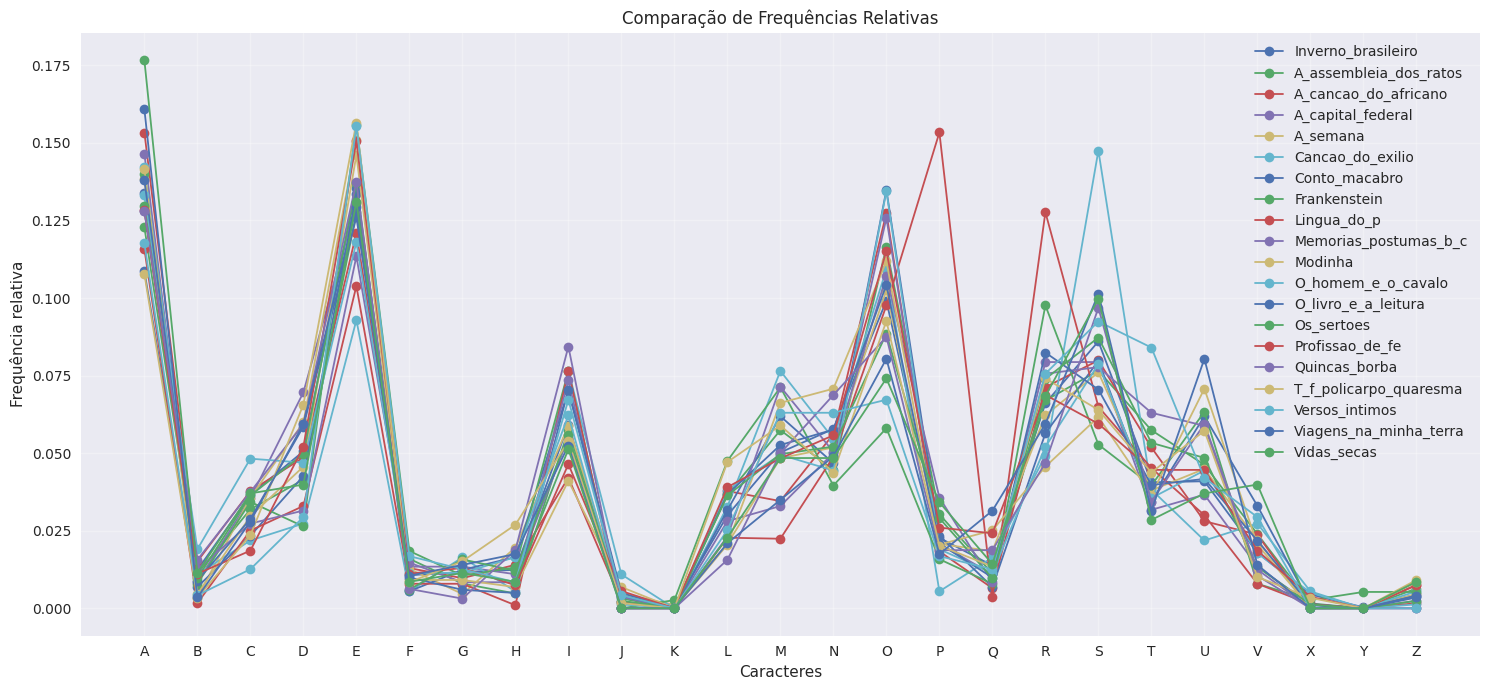

In [63]:
plot_freqs_linha(textos)

O gráfico apresenta a comparação das frequências relativas das letras do alfabeto em diversos textos literários. Cada linha representa um livro ou obra diferente.

As letras A, E, O aparecem com picos muito claros e são, de longe, as mais usadas. Essa predominância é um motivo pelo qual ataques por análise de frequência funcionam em cifras simples como a de César.

Letras como K, W, Y, além de Z, aparecem praticamente zeradas.
Isso era esperado, já que essas letras são pouco usadas no português, surgindo apenas em palavras estrangeiras ou nomes próprios específicos.

A forte sobreposição das linhas mostra que:
As diferenças entre obras existem, mas são muito pequenas comparadas à estrutura geral do idioma. A consequência prática é que a língua portuguesa tem uma “assinatura” estatística muito marcada.

## **Análise de Desempenho dos Algoritmos Criptográficos**

Para avaliar a eficácia e segurança dos algoritmos de criptografia, vamos analisar diversas métricas após a aplicação de cada algoritmo aos textos originais. Isso nos permitirá comparar o desempenho e as características dos textos cifrados e decifrados.

### **Métricas de Avaliação Detalhadas e Comparativos**

#### **Tempo de Criptografia/Descriptografia**

Esta métrica mede o tempo necessário para um algoritmo criptografar e descriptografar um determinado texto. É crucial para entender a eficiência operacional de cada algoritmo, especialmente em cenários de alta demanda ou com grandes volumes de dados. Um algoritmo mais rápido pode ser preferível, desde que não comprometa a segurança.

*   **Gráficos Comparativos:**

In [64]:
def cesar_cifrar(texto):
    return cesar.cifrar(texto, chave=3)

def cesar_ataque(texto):
    return cesar.ataque_cesar(texto)

def cesar_decifrar(texto):
    return cesar.decifrar(texto,chave=3)



def vigenere_cifrar(texto):
    return encriptar_decriptar(texto, chave="cripto", opcao="cifrar")

def vigenere_ataque(texto):
    return vigenere_ataq.atacar(texto)

def vigenere_decifrar(texto_cifrado):
    return encriptar_decriptar(texto_cifrado, chave="cripto", opcao="decifrar")


# ----------------------------------------
# CONFIGURAÇÕES
# ----------------------------------------
BITS_PARA_TESTE = 2048
MAX_RSA_BYTES = BITS_PARA_TESTE // 8 - 1
E_PARA_TESTE    = 101


# ----------------------------------------
# RSA: CIFRAR
# ----------------------------------------
def rsa_cifrar(texto):
    """
    Gera um caso RSA relacionado (Franklin–Reiter) e devolve c1.
    O caso inteiro é salvo em rsa_cifrar.last_case.
    """

    texto_limitado = texto[:MAX_RSA_BYTES]

    if not texto_limitado:
        raise ValueError("Texto vazio após limitação de tamanho.")

    caso = gerador_caso_relacionado_linear(
        texto1=texto_limitado,
        bits=BITS_PARA_TESTE,
        e_inicial=E_PARA_TESTE
    )

    # Salva o caso para decifrar e atacar depois
    rsa_cifrar.last_case = caso

    # c1 é um inteiro → devolvemos string
    return str(caso["c1"])
    

# ----------------------------------------
# RSA: DECIFRAR
# ----------------------------------------
def rsa_decifrar(texto_cifrado):

    if not hasattr(rsa_cifrar, "last_case"):
        raise RuntimeError("RSA ainda não cifrou nenhum texto.")

    caso = rsa_cifrar.last_case

    c = int(texto_cifrado)
    d = caso["d"]
    n = caso["n"]
    nbytes = caso["nbytes"]

    m = pow(c, d, n)
    return inteiro_para_texto(m, nbytes)


# ----------------------------------------
# RSA: ATAQUE FRANKLIN–REITER
# (usa o MESMO caso do cifrar)
# ----------------------------------------
def ataque_rsa(texto_cifrado):

    if not hasattr(rsa_cifrar, "last_case"):
        raise RuntimeError("RSA ainda não cifrou nenhum texto (nenhum caso disponível).")

    caso = rsa_cifrar.last_case

    return ataque_franklin_reiter(
        caso["c1"],
        caso["c2"],
        caso["e"],
        caso["n"],
        caso["a"],
        caso["b"],
        caso["nbytes"],
        d=caso.get("d"),
    )


algoritmos_combinados = {
    "César": {
        "cifrar": cesar_cifrar,
        "decifrar": cesar_decifrar,
        "atacar": cesar_ataque
    },
     "Vigenere": {
        "cifrar": vigenere_cifrar,
        "decifrar": vigenere_decifrar,
        "atacar": vigenere_ataque
    },
    "RSA": {
        "cifrar": rsa_cifrar,
        "decifrar": rsa_decifrar,
        "atacar": ataque_rsa
    },
}


primeiros_5_itens = dict(list(textos.items())[:5])

comparacao = comparar_algoritmos(primeiros_5_itens, algoritmos_combinados)

processado: ('César', 'Inverno_brasileiro')
processado: ('César', 'A_assembleia_dos_ratos')
processado: ('César', 'A_cancao_do_africano')
processado: ('César', 'A_capital_federal')
processado: ('César', 'A_semana')
processado: ('Vigenere', 'Inverno_brasileiro')
processado: ('Vigenere', 'A_assembleia_dos_ratos')
processado: ('Vigenere', 'A_cancao_do_africano')
processado: ('Vigenere', 'A_capital_federal')
processado: ('Vigenere', 'A_semana')


processado: ('RSA', 'Inverno_brasileiro')
processado: ('RSA', 'A_assembleia_dos_ratos')
processado: ('RSA', 'A_cancao_do_africano')
processado: ('RSA', 'A_capital_federal')
processado: ('RSA', 'A_semana')


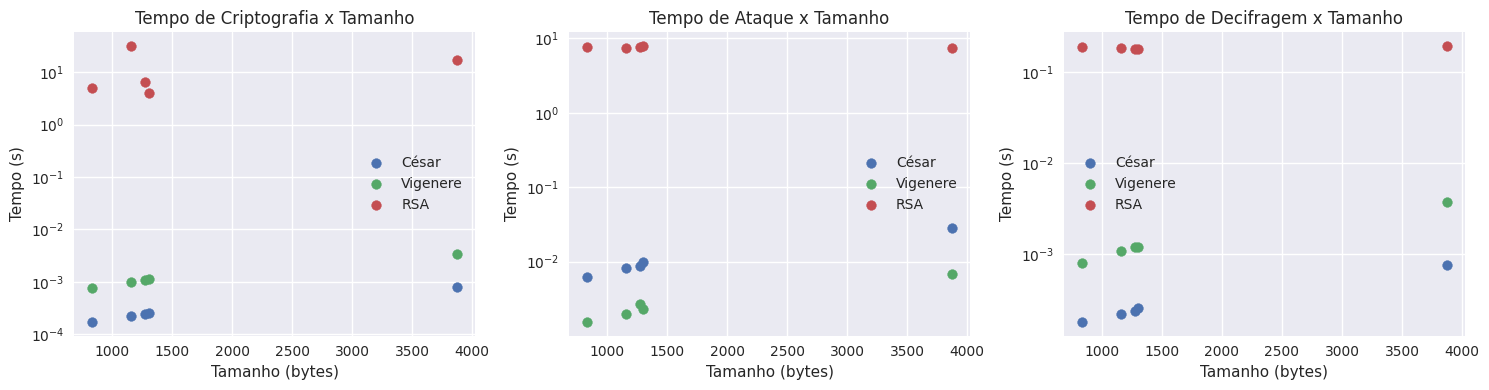

In [65]:
def plot_tempos(comparacao):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    metricas = ["tempo_cifra", "tempo_ataque", "tempo_decifra"]
    titulos = ["Tempo de Criptografia", "Tempo de Ataque", "Tempo de Decifragem"]
    
    for ax, metrica, titulo in zip(axs, metricas, titulos):
        for alg, textos_alg in comparacao.items():
            tamanhos = [dados["tamanho"] for dados in textos_alg.values()]
            tempos   = [dados[metrica]        for dados in textos_alg.values()]
            
            ax.scatter(tamanhos, tempos, marker="o", label=alg)
        
        ax.set_title(f"{titulo} x Tamanho")
        ax.set_xlabel("Tamanho (bytes)")
        ax.set_ylabel("Tempo (s)")
        ax.set_yscale("log")
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()
plot_tempos(comparacao)

César e Vigenere ficam praticamente colados próximos de 10⁻³ a 10⁻⁴ s, ou seja, criptografam quase instantaneamente, mesmo quando o tamanho cresce para quase 4000 bytes. Enquanto isso o RSA explode para valores entre 1 s e até 20 s, aumentando de forma acentuada com o tamanho.

Com isso interpretamos que cifras clássicas são extremamente leves e praticamente não se importam com o tamanho do texto e RSA é ordens de magnitude mais lento.

Tempo de Ataque x Tamanho:

De novo, César e Vigenere estão muito baixos, entre 10⁻³ e 10⁻² s. Quando parte para o ataque, o custo cresce um pouco para Vigenere (faz sentido por precisar testar chaves, frequência), mas nada dramático. Em contrapartida o RSA fica em torno de 10 a 15 s, com crescimento perceptível.

 Tempo de Decifragem x Tamanho

César e Vigenere: novamente tempos desprezíveis (~10⁻³ s). Seguido do RSA com tempos entre 0.1 e 0.3 s, com um ponto maior (~1 s) para o maior tamanho.

Concluímos que: A decifragem RSA é bem mais rápida que a criptografia RSA, o que é normal: a chave privada usa expoente menor. Mas ainda assim é muito mais lenta que cifras clássicas.

César e Vigenere têm desempenho impecável — não variam quase nada com o tamanho, praticamente instantâneos em todas as operações.

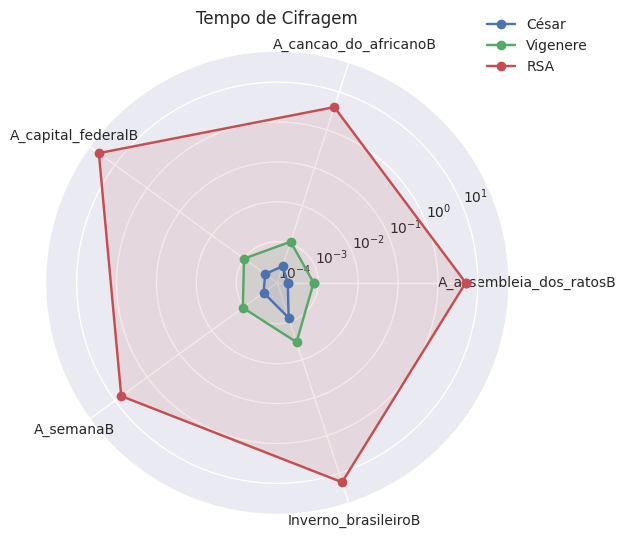

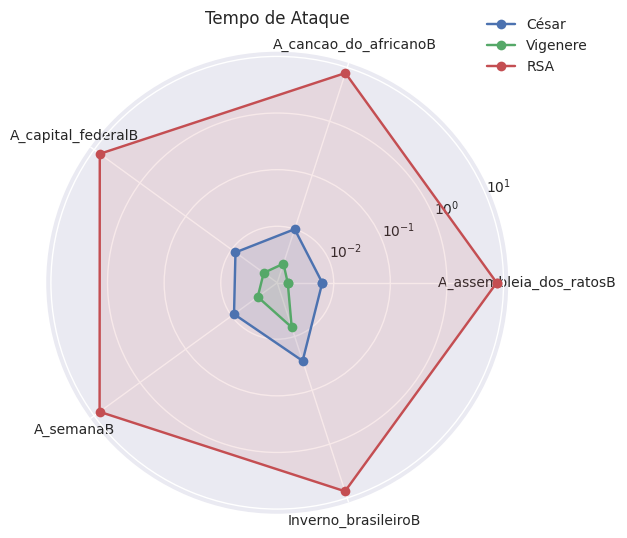

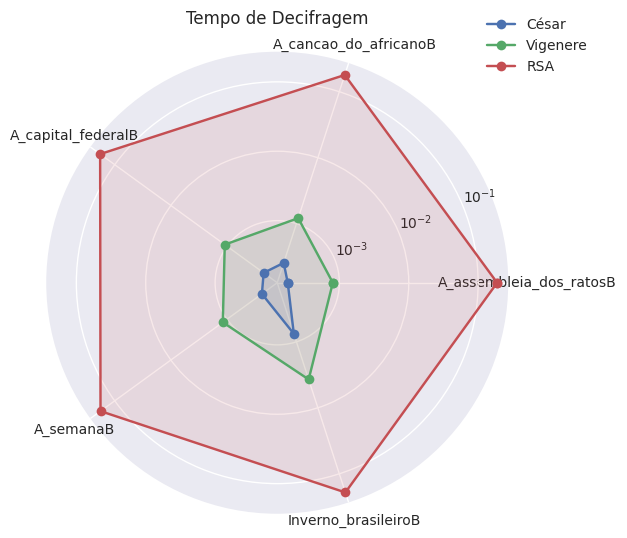

In [66]:
def plot_radar(comparacao):
    metricas = {
        "tempo_cifra": "Tempo de Cifragem",
        "tempo_ataque": "Tempo de Ataque",
        "tempo_decifra": "Tempo de Decifragem",
    }

    # Para cada métrica, criamos um radar separado
    for metrica, titulo in metricas.items():

        fig = plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, polar=True)

        # ângulos (quantos tamanhos houver)
        tamanhos = list(next(iter(comparacao.values())).keys())
        tamanhos = sorted(tamanhos)  # garantir ordem crescente
        n = len(tamanhos)

        angulos = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
        angulos += angulos[:1]

        # Plotar cada algoritmo com TODOS os valores
        for alg, textos_alg in comparacao.items():
            valores = [textos_alg[t][metrica] for t in tamanhos]
            valores += valores[:1]  # fechar polígono

            ax.plot(angulos, valores, marker='o', label=alg)
            ax.fill(angulos, valores, alpha=0.12)

        # Escala logarítmica no eixo radial
        ax.set_rscale("log")

        # Ajustes de rótulos e aparência
        ax.set_xticks(angulos[:-1])
        ax.set_xticklabels([f"{t}B" for t in tamanhos])
        ax.set_title(titulo, pad=20)
        ax.grid(True)
        plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
        plt.show()
plot_radar(comparacao)

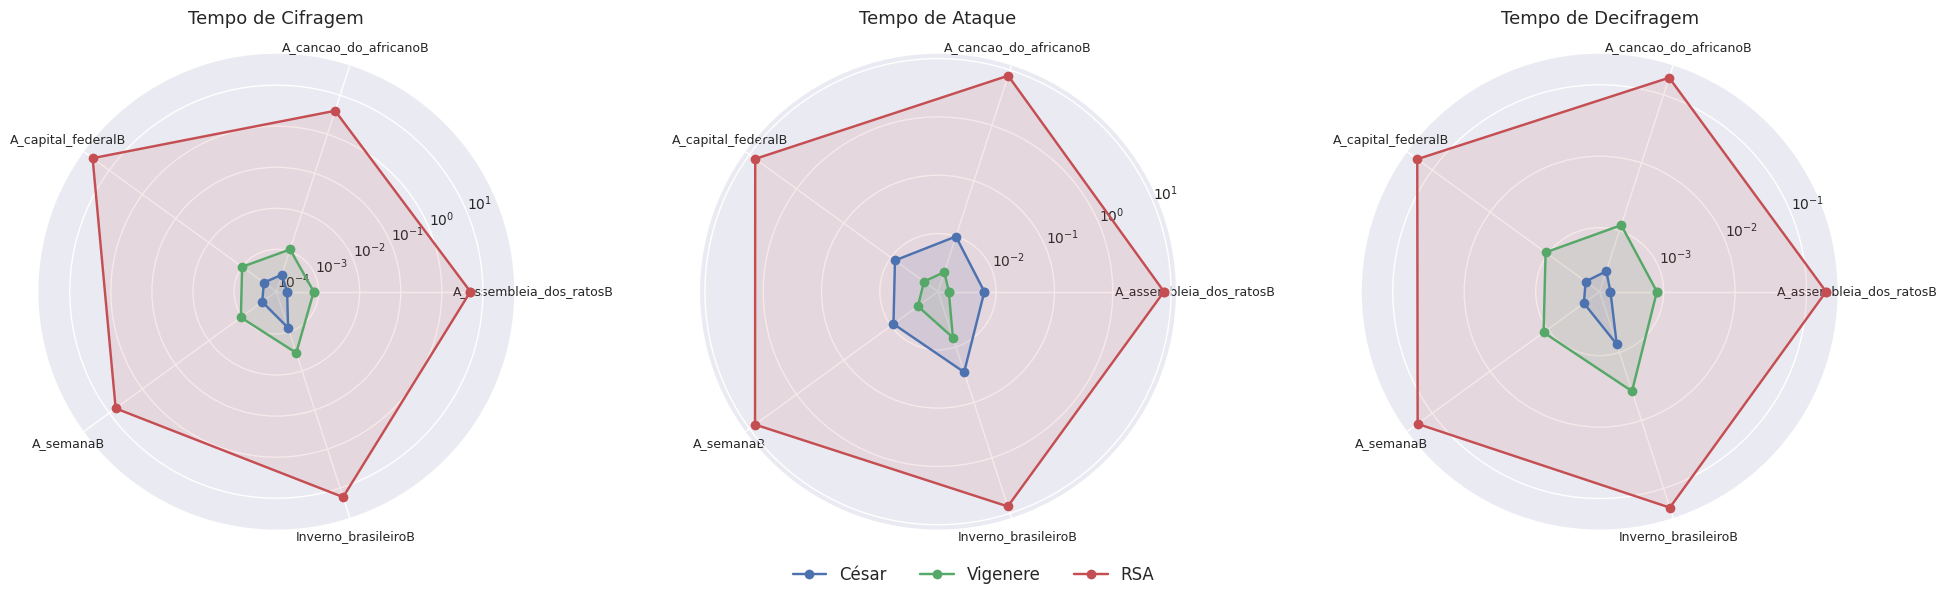

In [67]:
def plot_polar_todos_lado_a_lado_rotulos_inclinados(comparacao):

    metricas = [
        ("tempo_cifra",  "Tempo de Cifragem"),
        ("tempo_ataque", "Tempo de Ataque"),
        ("tempo_decifra","Tempo de Decifragem")
    ]

    tamanhos = sorted(list(next(iter(comparacao.values())).keys()))
    n = len(tamanhos)

    angulos = np.linspace(0, 2 * np.pi, n, endpoint=False)
    angulos_full = np.concatenate([angulos, [angulos[0]]])

    fig, axs = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(polar=True))

    for ax, (metrica, titulo) in zip(axs, metricas):

        for alg, textos_alg in comparacao.items():
            valores = [textos_alg[t][metrica] for t in tamanhos]
            valores = valores + [valores[0]]

            ax.plot(angulos_full, valores, marker='o', label=alg)
            ax.fill(angulos_full, valores, alpha=0.12)

        # Escala log
        ax.set_rscale("log")

        # Rótulos angulares com inclinação
        ax.set_xticks(angulos)
        ax.set_xticklabels([f"{t}B" for t in tamanhos], fontsize=9)
        ax.tick_params(axis='x', labelrotation=0)  # <<< inclinação

        ax.set_title(titulo, pad=12, fontsize=13)

        # deixar circular e grande
        ax.set_aspect("equal", adjustable="box")
        ax.set_anchor("C")

    # Legenda abaixo da figura
    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)

    plt.tight_layout(rect=[0, 0.07, 1, 1])
    plt.show()
plot_polar_todos_lado_a_lado_rotulos_inclinados(comparacao)

César e Vigenère são praticamente invisíveis no gráfico, Isso ocorre porque como visto anteriormente ambos são extremamente leves.
O tempo deles é tão pequeno que fica colado no centro do radar.

Em comparação ao RSA, sua escala é praticamente zero.

O gráfico evidencia perfeitamente que:

RSA é inadequado para cifrar textos grandes diretamente.
Deve ser usado apenas para cifrar chaves simétricas, não mensagens inteiras.
Cifrar mensagens com RSA puro escala muito mal.

#### **Autocorrelação e Coocorrência**


A autocorrelação mede o grau de similaridade entre um texto e uma versão deslocada (shifted) de si mesmo. Em outras palavras, ela nos diz o quão provável é que um caractere em uma posição seja o mesmo que um caractere em uma posição n casas adiante no texto. É uma ferramenta fundamental para encontrar padrões repetitivos em dados.

Em textos cifrados (especialmente aqueles gerados por cifras de período fixo como Vigenère), a autocorrelação é usada para identificar o comprimento da chave. Se você deslocar um texto cifrado por um número de posições igual ao comprimento da chave, você tende a ver um aumento nas "coincidências" ou similaridades, pois o mesmo caractere do texto original estará sendo cifrado pela mesma letra da chave. Ao plotar a autocorrelação para diferentes deslocamentos (shifts), picos significativos podem indicar múltiplos do comprimento da chave.

A coocorrência (também conhecida como digrama ou bigrama) mede a frequência com que pares de caracteres aparecem juntos, em uma determinada ordem e distância. Por exemplo, a coocorrência de 'QU' em português é alta, enquanto 'QX' é muito baixa. Mais especificamente, uma matriz de coocorrência para shift=1 mostra a probabilidade de um caractere Y seguir um caractere X.

Em textos em linguagem natural, a coocorrência reflete a estrutura gramatical e fonética. Certos pares de letras são muito mais comuns do que outros. Um algoritmo de criptografia eficaz deve destruir esses padrões de coocorrência. Se um texto cifrado ainda exibir padrões de coocorrência semelhantes aos da linguagem natural, ele pode ser vulnerável a ataques de análise de frequência de digramas ou outros métodos estatísticos que buscam identificar pares de letras comuns na língua original.

Ambas as métricas são usadas para avaliar a "aleatoriedade" introduzida por um cifrador e para identificar vulnerabilidades em cifras que não mascaram adequadamente as propriedades estatísticas da linguagem original.

*   **Gráficos Comparativos:**

Coletando dados para: César — Inverno_brasileiro
Coletando dados para: Vigenere — Inverno_brasileiro
Coletando dados para: RSA — Inverno_brasileiro


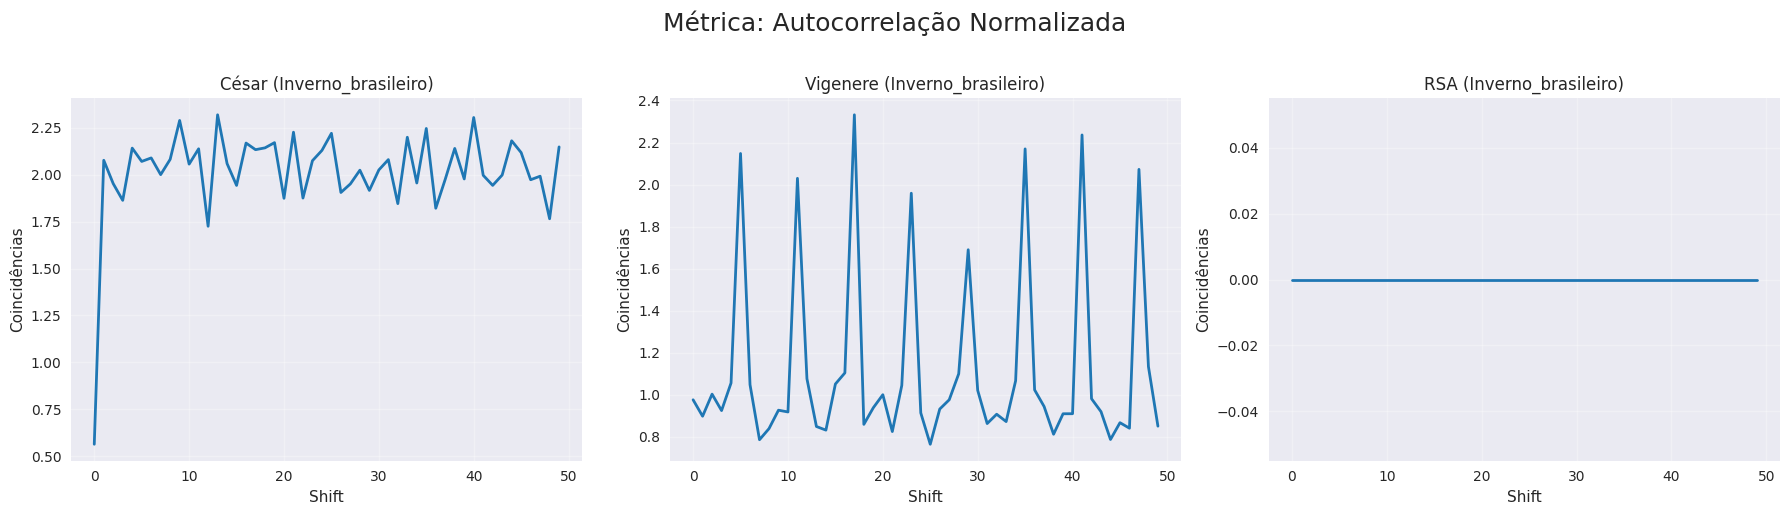

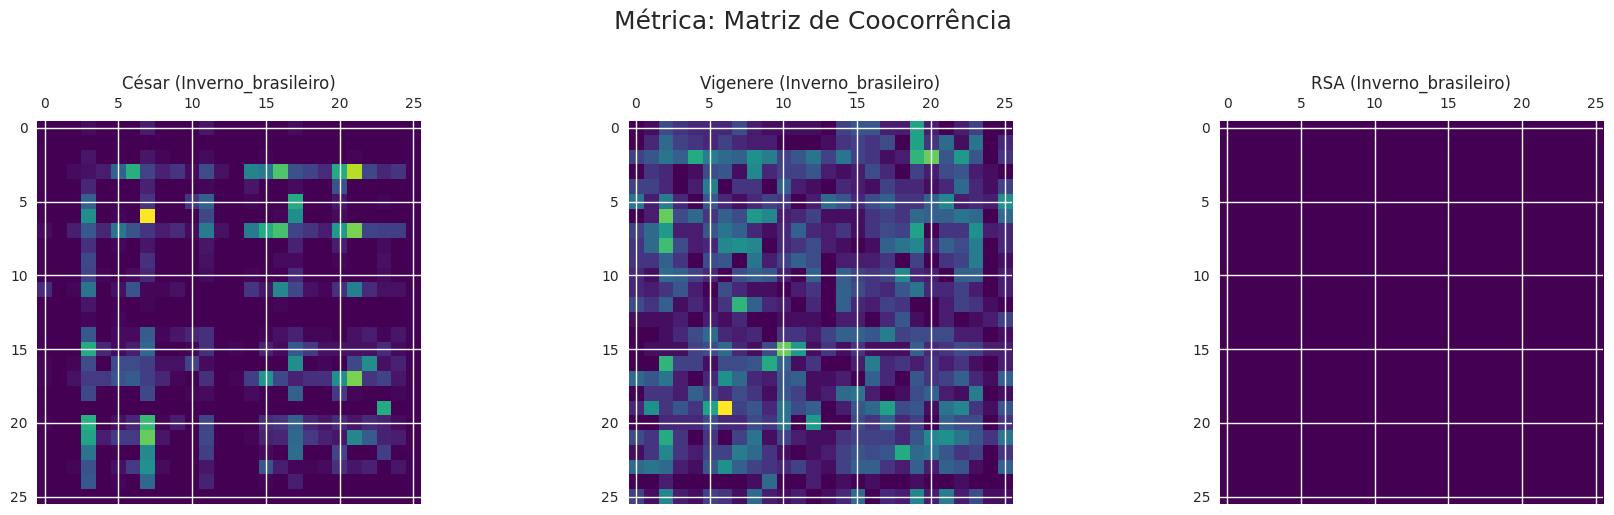

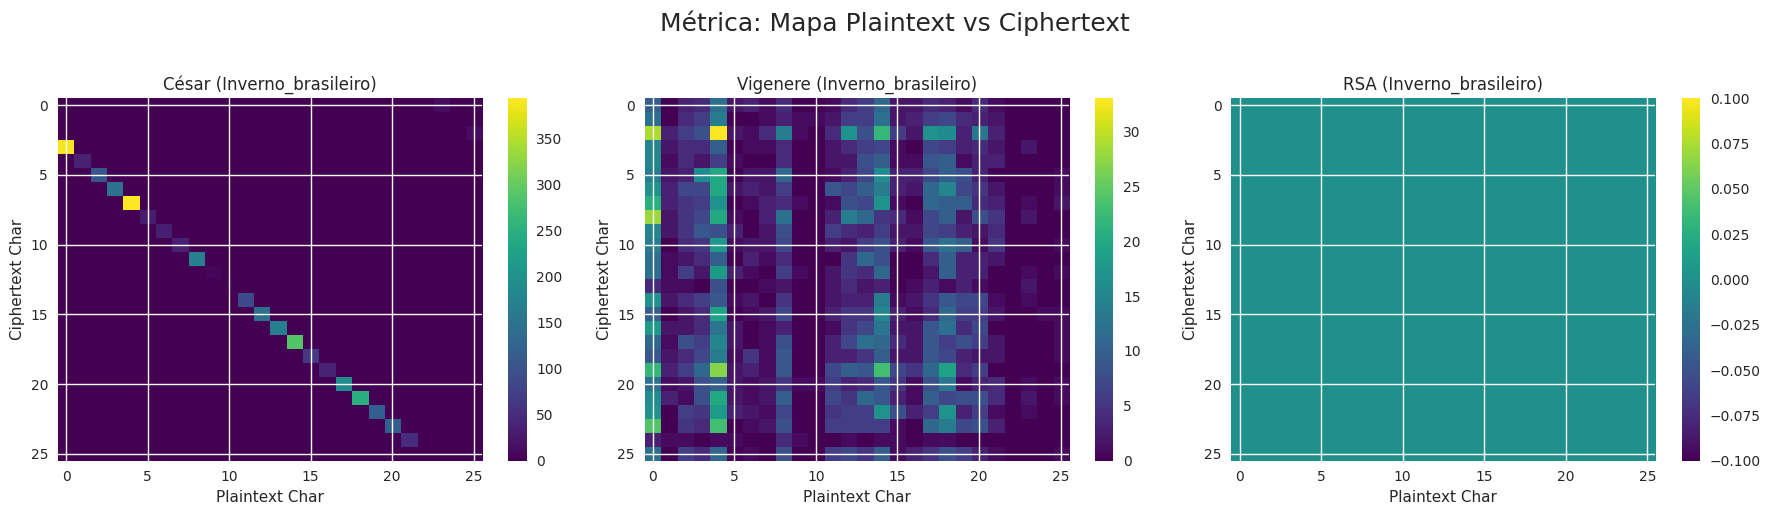

In [68]:
def plot_autocorrelacao_normalizada(data, nome_alg, nome_txt, ax=None):
    plt.style.use("seaborn-v0_8")
    ax = ax or plt.gca()
    
    ax.plot(data, color="tab:blue", linewidth=2)
    
    # 2. Configurações de Título e Rótulos (copiadas do seu axs[0])
    ax.set_title("Autocorrelação", fontsize=13)
    ax.set_xlabel("Shift", fontsize=11)
    ax.set_ylabel("Coincidências", fontsize=11)
    
    # 3. Grade com transparência (copiada do seu axs[0])
    ax.grid(alpha=0.3)

def plot_coocorrencia(data, nome_alg, nome_txt, ax=None):
    ax = ax or plt.gca()
    ax.matshow(data, cmap='viridis')
    ax.set_title("Matriz (Heatmap)", fontsize=10)

def plot_matriz_original_vs_cifrada(data, nome_alg, nome_txt, ax=None):
    ax = ax or plt.gca()
    
    data_np = np.array(data)

    if data_np.ndim == 2:
        cax = ax.imshow(data_np, cmap='viridis', aspect='auto')
        
        plt.colorbar(cax, ax=ax)
        
        ax.set_title("Mapa 2D (Heatmap)", fontsize=10)
        ax.set_xlabel("Plaintext Char")
        ax.set_ylabel("Ciphertext Char")
        
    elif data_np.ndim == 1:
        ax.scatter(range(len(data_np)), data_np, s=5)
        
        ax.set_title("Mapa 1D (Dispersão)", fontsize=10)
        ax.set_xlabel("Plaintext Char Index")
        ax.set_ylabel("Ciphertext Char Index (Valor)")
        
    else:
        # Erro se o formato for inesperado
        ax.text(0.5, 0.5, 'ERRO: Dados com dimensão inesperada.', 
                transform=ax.transAxes, ha='center', color='red')
        ax.axis('off')
        print(f"Aviso: Dados de mapa_original_cifrada para {nome_alg} não são 1D nem 2D.")

def coletar_metricas(comparacao):
    """
    Itera sobre os algoritmos e coleta os dados das métricas
    do PRIMEIRO livro encontrado para cada um, agrupando por tipo de métrica.
    """
    metricas_agrupadas = {
        "autocorrelacao_normalizada": [],
        "coocorrencia": [],
        "mapa_original_cifrada": []
    }

    for nome_alg, textos in comparacao.items():
        
        # Selecionar Apenas o Primeiro Texto (Livro)
        try:
            nome_txt, info = next(iter(textos.items()))
        except StopIteration:
            print(f"Aviso: Nenhuma informação de texto encontrada para o algoritmo: {nome_alg}")
            continue

        print(f"Coletando dados para: {nome_alg} — {nome_txt}")
        
        # Coletar e Agrupar Dados
        
        # 1. Autocorrelação
        if "autocorrelacao_normalizada" in info:
            metricas_agrupadas["autocorrelacao_normalizada"].append({
                "alg": nome_alg, "txt": nome_txt, "data": info["autocorrelacao_normalizada"]
            })

        # 2. Coocorrência
        if "coocorrencia" in info:
            metricas_agrupadas["coocorrencia"].append({
                "alg": nome_alg, "txt": nome_txt, "data": info["coocorrencia"]
            })

        # 3. Mapa plaintext -> ciphertext
        if "mapa_original_cifrada" in info:
            metricas_agrupadas["mapa_original_cifrada"].append({
                "alg": nome_alg, "txt": nome_txt, "data": info["mapa_original_cifrada"]
            })
        
    return metricas_agrupadas


def plotar_em_grid(dados_metricos, titulo_metrica, funcao_plotagem_especifica):
    """Cria uma figura com subplots, plotando uma métrica por algoritmo."""
    num_algoritmos = len(dados_metricos)
    if num_algoritmos == 0:
        return

    cols = min(4, num_algoritmos) 
    rows = math.ceil(num_algoritmos / cols) 

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    fig.suptitle(f"Métrica: {titulo_metrica}", fontsize=18, y=1.02)
    
    if rows == 1 and cols == 1:
        axes_list = [axes]
    else:
        axes_list = axes.flatten() 

    for i, item in enumerate(dados_metricos):
        ax = axes_list[i]
        
        funcao_plotagem_especifica(item["data"], item["alg"], item["txt"], ax=ax)
        
        ax.set_title(f"{item['alg']} ({item['txt']})", fontsize=12)
        
    for j in range(num_algoritmos, len(axes_list)):
        fig.delaxes(axes_list[j])

    plt.tight_layout()
    plt.show()

def plotar_metricas_agrupadas(comparacao):
    """
    Coleta os dados e os envia para a plotagem em grid,
    organizando os algoritmos lado a lado por métrica.
    """
    metricas_agrupadas = coletar_metricas(comparacao)
    
    plotar_em_grid(
        metricas_agrupadas["autocorrelacao_normalizada"],
        "Autocorrelação Normalizada",
        plot_autocorrelacao_normalizada 
    )
    
    # --- Coocorrência ---
    plotar_em_grid(
        metricas_agrupadas["coocorrencia"],
        "Matriz de Coocorrência",
        plot_coocorrencia 
    )
    
    # --- Mapa plaintext → ciphertext ---
    plotar_em_grid(
        metricas_agrupadas["mapa_original_cifrada"],
        "Mapa Plaintext vs Ciphertext",
        plot_matriz_original_vs_cifrada 
    )
plotar_metricas_agrupadas(comparacao)



##### Análise: Autocorrelação Normalizada


* **César:** O gráfico é relativamente **plano e alto** (em torno de 1.7 a 2.2).
    * Não há picos regulares, pois a chave é apenas um *shift* fixo (tamanho 1). O valor alto de coincidência indica que a estrutura da linguagem original (Português) foi totalmente preservada, tornando-a vulnerável à análise de frequência simples.
* **Vigenère:** O gráfico exibe **picos nítidos e regulares**.
    * Os picos (coincidências) ocorrem em intervalos regulares que correspondem aos múltiplos do comprimento da chave. Isso acontece porque, nesses *shifts*, o mesmo caractere do texto original está sendo cifrado pela mesma letra da chave. Este padrão é a maior vulnerabilidade de Vigenère.
* **RSA:** O gráfico é essencialmente **zero e plano**.
    * Como o RSA cifra em números gigantes e não em letras (e qualquer padrão de letra é destruído por difusão), não há correlação estatística entre o bloco cifrado e um bloco deslocado. O resultado é consistentemente próximo de zero, refletindo a natureza aleatória e não-textual do *ciphertext*.

##### Análise: Mapa Plaintext vs. Ciphertext

Este mapa  mostra quantas vezes uma letra do texto claro (Plaintext Char - Eixo X) é mapeada para uma letra do texto cifrado (Ciphertext Char - Eixo Y).


* **César:** Apresenta uma **linha diagonal** muito clara (monoalfabética).
    * Cada letra do *plaintext* mapeia para apenas uma letra do *ciphertext*. A substituição é fixa e de 1:1. O *shift* diagonal é exatamente o valor da chave.
* **Vigenère:** Apresenta **múltiplas faixas ou colunas dispersas** (polialfabética).
    * Uma única letra do *plaintext* (coluna X) mapeia para várias letras diferentes no *ciphertext* (dispersão na coluna Y), dependendo da posição da chave. A mesma letra do texto claro é cifrada por diferentes letras da chave, destruindo o mapeamento fixo 1:1 e caracterizando uma cifra polialfabética.
* **RSA:** O gráfico é **totalmente plano** e com valores muito baixos ou nulos.
    * O RSA opera em blocos de bits muito grandes, e não em caracteres individuais. A correlação entre um único caractere do *plaintext* e um único caractere do *ciphertext* (se o resultado fosse forçosamente convertido para letras) é nula devido à natureza da aritmética modular e da difusão do algoritmo.

##### Análise: Matriz de Coocorrência

A matriz de coocorrência  mostra a frequência com que pares de caracteres aparecem juntos (digramas).


* **César:** Apresenta um **padrão estruturado e disperso**.
    * O padrão de coocorrência da linguagem natural é preservado (se 'QU' é comum no texto claro, o *shift* de 'QU' ainda será comum no texto cifrado). Os *hotspots* indicam os digramas mais comuns do Português após o *shift* da chave.
* **Vigenère:** O padrão é **homogêneo** e **mais próximo da aleatoriedade**.
    * A cifra destrói a maioria dos padrões de coocorrência. O gráfico é mais uniforme, com poucas áreas de alta concentração, indicando que os pares de letras são distribuídos de forma mais equitativa.
* **RSA:** O gráfico é **completamente homogêneo** (tons de verde/ciano claros).
    * Semelhante aos outros gráficos, a correlação entre qualquer par de caracteres é zero, resultando em uma matriz completamente plana e homogênea.


#### **Índice de Coincidência (IC)**

O Índice de Coincidência é uma ferramenta estatística utilizada para medir a probabilidade de que dois caracteres escolhidos aleatoriamente de um texto sejam iguais. Para textos em linguagem natural, o IC é relativamente alto. Após a criptografia, espera-se que o IC de um texto cifrado seja significativamente menor e próximo ao de um texto aleatório, indicando que a estrutura da linguagem original foi mascarada.  Se o IC do texto cifrado ainda for alto, isso sugere que o algoritmo não randomizou suficientemente o texto e pode ser vulnerável a ataques de análise de frequência.



#### **Entropia**

A entropia quantifica a aleatoriedade e a imprevisibilidade. Um bom algoritmo criptográfico visa maximizar a entropia do texto cifrado.
Um algoritmo de criptografia robusto deve pegar um texto com baixa entropia e alto IC (o plaintext) e transformá-lo em um ciphertext que tenha alta entropia e baixo IC. Idealmente, o IC do texto cifrado deve ser próximo ao de um texto completamente aleatório (que é ~0.038 para um alfabeto de 26 letras), e sua entropia deve ser alta, indicando que as propriedades estatísticas da linguagem original foram mascaradas.

*   **Gráficos Comparativos:**

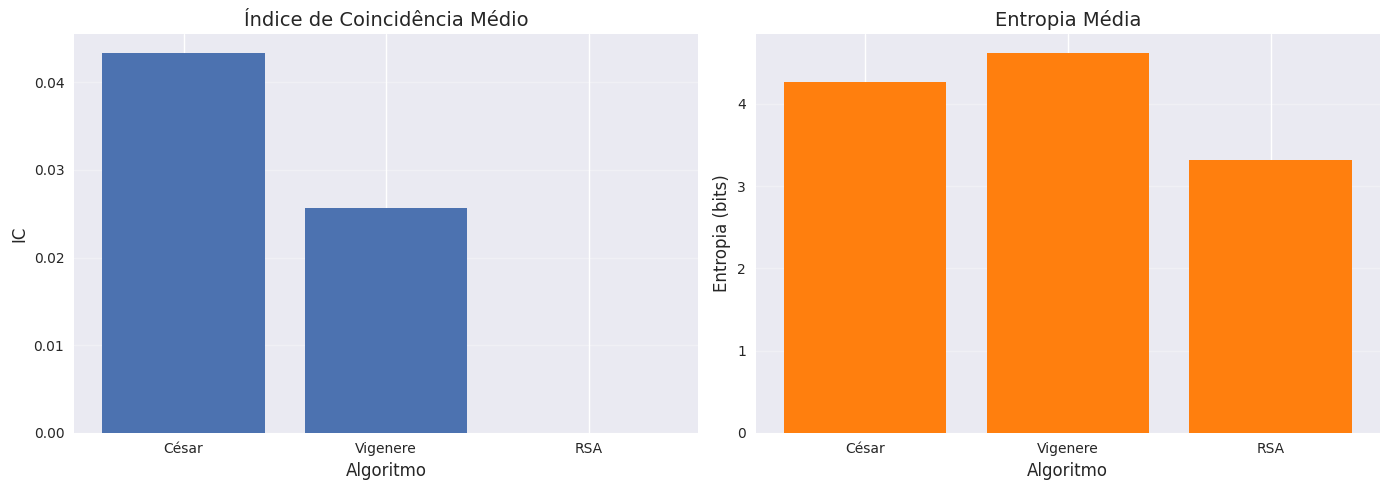

In [69]:
plt.style.use("seaborn-v0_8") 

def plot_ic_e_entropia_lado_a_lado(comparacao):
    # Dicionários para armazenar as médias
    medias_ic = {}
    medias_entropia = {}
    
    # 1. Processamento dos Dados
    for alg, textos in comparacao.items():
        
        # Cálculo da Média do IC
        media_ic = sum(t["IC"] for t in textos.values()) / len(textos)
        medias_ic[alg] = media_ic
        
        # Cálculo da Média da Entropia
        media_entropia = sum(t["entropia"] for t in textos.values()) / len(textos)
        medias_entropia[alg] = media_entropia
        
    algs = list(medias_ic.keys()) # Lista de nomes dos algoritmos

    # 2. Criação da Figura com 1 linha e 2 colunas de subplots
    # Aumentamos o figsize para acomodar os dois gráficos horizontalmente
    fig, axs = plt.subplots(1, 2, figsize=(14, 5)) 

    # --- GRÁFICO 1: ÍNDICE DE COINCIDÊNCIA ---
    
    # Plota no primeiro eixo (coluna 0)
    axs[0].bar(algs, medias_ic.values())
    axs[0].set_title("Índice de Coincidência Médio", fontsize=14)
    axs[0].set_xlabel("Algoritmo", fontsize=12)
    axs[0].set_ylabel("IC", fontsize=12)
    axs[0].grid(axis='y', alpha=0.3) # Adiciona grade horizontal leve para leitura

    # --- GRÁFICO 2: ENTROPIA ---
    
    # Plota no segundo eixo (coluna 1)
    axs[1].bar(algs, medias_entropia.values(), color='tab:orange') # Usando outra cor para diferenciação
    axs[1].set_title("Entropia Média", fontsize=14)
    axs[1].set_xlabel("Algoritmo", fontsize=12)
    axs[1].set_ylabel("Entropia (bits)", fontsize=12)
    axs[1].grid(axis='y', alpha=0.3) # Adiciona grade horizontal leve
    
    # Ajusta o espaçamento entre os subplots para evitar sobreposição
    plt.tight_layout()
    
    # Exibe a figura combinada
    plt.show()


plot_ic_e_entropia_lado_a_lado(comparacao)

• Cifra de César — IC ≈ 0,042
• César — Entropia ≈ 4,3 bits

O IC permanece relativamente alto, enquanto a Entropia permanece semelhante ao texto original, pois o algoritmo de César não altera a distribuição das letras, apenas desloca o alfabeto. Dessa forma, o padrão linguístico do português é preservado quase integralmente. Isso indica que essa cifra é altamente vulnerável à análise de frequência, sendo possível recuperar a mensagem com relativa facilidade.

• Cifra de Vigenère — IC ≈ 0,026
Vigenère — Entropia ≈ 4,6 bits
O IC reduz-se significativamente, aproximando-se do valor esperado para um texto aleatório, apresentando uma entropia próxima ao máximo teórico para um alfabeto de 26 símbolos (≈ 4,70 bits). Isso ocorre porque a cifra de Vigenère utiliza deslocamentos variados ao longo do texto, reduzindo a repetitividade e “achatando” a distribuição de frequências. Assim, essa cifra oculta de maneira mais eficaz os padrões estatísticos naturais da língua.

• RSA — IC praticamente nulo
Entropia ≈ 3,3 bits
No caso do RSA, o IC e a Entropia não é uma métrica aplicável. A saída do algoritmo é composta por blocos numéricos posteriormente convertidos para hexadecimal ou Base64, e não por letras do alfabeto português. Como consequência, o IC tende a valores próximos do ruído estatístico e perde totalmente seu significado linguístico. Portanto, essa métrica não deve ser usada para avaliar segurança do RSA.

#### **Expansão de Tamanho**

Esta métrica avalia o quanto o tamanho do texto cifrado se expande em relação ao texto original. Alguns algoritmos criptográficos adicionam bytes extras (por exemplo, devido ao preenchimento - padding) ao texto original, resultando em um texto cifrado maior. A expansão excessiva pode ser um fator a considerar em aplicações com restrições de armazenamento ou largura de banda.

*   **Gráficos Comparativos:**

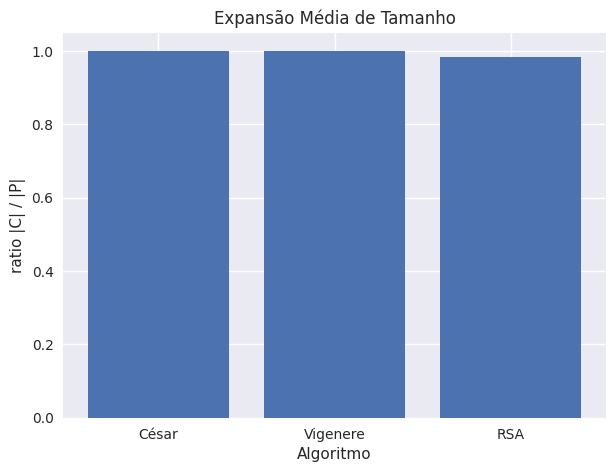

In [70]:
def plot_expansao(comparacao):
    algs = []
    valores = []

    for alg, textos in comparacao.items():
        media = sum(t["expansao"] for t in textos.values()) / len(textos)
        algs.append(alg)
        valores.append(media)

    plt.figure(figsize=(7,5))
    plt.bar(algs, valores)
    plt.title("Expansão Média de Tamanho")
    plt.xlabel("Algoritmo")
    plt.ylabel("ratio |C| / |P|")
    plt.show()

plot_expansao(comparacao)

Algoritmos Simétricos (César e Vigenere)

Os métodos de César e Vigenere exibem um valor igual a 1.0, indicando que não há expansão de tamanho.
Isso ocorre porque ambos pertencem à família de cifras de substituição, nas quais cada caractere do texto original é substituído por exatamente um caractere cifrado, como dito anteriormente.

Esse comportamento é esperado em cifras clássicas.

A variação observada no algoritmo RSA pode ser explicada pela necessidade de converter o texto cifrado para Base64. Como o RSA produz dados binários, sua saída não é diretamente representável como texto. Ao codificar em Base64. Como as cifras de César e Vigenere atuam diretamente sobre caracteres ASCII, não houve necessidade dessa conversão e, portanto, seus tamanhos permaneceram inalterados.

#### **Efeito Avalanche**

O efeito avalanche mede a propriedade de um algoritmo criptográfico onde uma pequena alteração no texto de entrada (ou na chave) resulta em uma grande alteração no texto de saída. Um bom efeito avalanche é essencial para a segurança, pois garante que mesmo pequenas modificações sejam propagadas extensivamente, dificultando a inferência de informações sobre o texto original ou a chave a partir do texto cifrado.

*   **Gráfico Comparativo:**

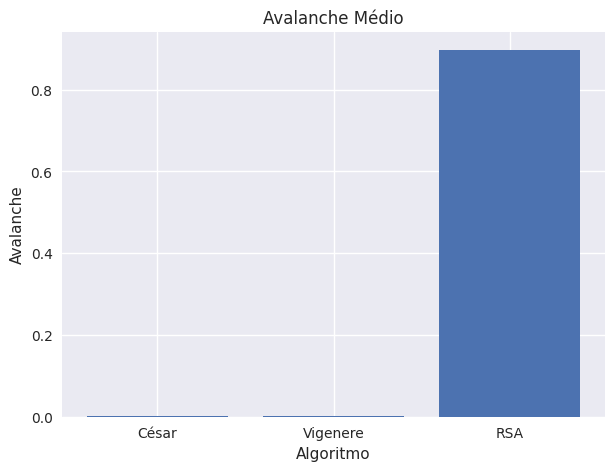

In [71]:
def plot_avalanche(comparacao):
    algs = []
    valores = []

    for alg, textos in comparacao.items():
        media = sum(t["avalanche"] for t in textos.values()) / len(textos)
        algs.append(alg)
        valores.append(media)

    plt.figure(figsize=(7,5))
    plt.bar(algs, valores)
    plt.title("Avalanche Médio")
    plt.xlabel("Algoritmo")
    plt.ylabel("Avalanche")
    plt.show()

plot_avalanche(comparacao)

Cifra de César — Avalanche ≈ 0%

A cifra de César apresenta um valor médio de avalanche praticamente nulo. Esse resultado é esperado porque:

Trata-se de uma simples substituição monoalfabética com deslocamento fixo.

Uma alteração mínima no texto claro afeta apenas o caractere correspondente, sem propagar mudanças.

O restante da mensagem permanece totalmente inalterado

RSA — Avalanche ≈ 0,90 (ou seja, ~90%)

O algoritmo RSA apresenta um efeito avalanche elevado, superior a 90%, indicando que uma pequena alteração no texto claro provoca mudanças significativas no bloco cifrado.

Esse comportamento é consequência direta de sua estrutura matemática:

O RSA opera sobre inteiros muito grandes, elevando-os a uma potência modular.

Qualquer alteração mínima no valor numérico da entrada modifica completamente o resultado da exponenciação.

A transformação é altamente sensível, uma característica essencial para sistemas criptográficos modernos.

#### **Tabela separada por texto e algoritmo**

Segue os dados obtidos dos algoritmos.

In [72]:
def tabela_metricas(comparacao):
    dados = []
    
    for nome_alg, textos_metricas in comparacao.items():
        for nome_texto, metricas in textos_metricas.items():
            
            dados.append({
                "Texto": nome_texto,
                "Algoritmo": nome_alg,
                "IC": metricas.get("IC"),
                "Expansao": metricas.get("expansao"),
                "Entropia": metricas.get("entropia"),
                "Tempo Cifra": metricas.get("tempo_cifra"),
                "Tempo Ataque": metricas.get("tempo_ataque"),
            })

    return pd.DataFrame(dados)

def tabela_metricas_pivot(comparacao):
    df = tabela_metricas(comparacao)
    return df.pivot(index="Texto", columns="Algoritmo")

tabela_metricas_pivot(comparacao)

IC                Expansao                      \
Algoritmo                  César  RSA  Vigenere    César       RSA  Vigenere   
Texto                                                                          
A_assembleia_dos_ratos  0.043477  0.0  0.026177      1.0  1.507335  1.000000   
A_cancao_do_africano    0.043656  0.0  0.024853      1.0  0.975475  0.996835   
A_capital_federal       0.044519  0.0  0.026673      1.0  1.102862  1.000000   
A_semana                0.040009  0.0  0.024252      1.0  1.004072  1.000000   
Inverno_brasileiro      0.044919  0.0  0.026564      1.0  0.324730  1.000000   

                        Entropia                     Tempo Cifra             \
Algoritmo                  César       RSA  Vigenere       César        RSA   
Texto                                                                         
A_assembleia_dos_ratos  4.313496  3.316982  4.676446    0.000171   4.971457   
A_cancao_do_africano    4.339945  3.311542  4.694705    0.000254   3.995535   
A_capital_federal       4.185540  3.317092  4.519979    0.000221  31.619050   
A_semana                4.258590  3.315765  4.568734    0.000248   6.395770   
Inverno_brasileiro      4.260223  3.317552  4.615735    0.000788  16.999852   

                                 Tempo Ataque                      
Algoritmo               Vigenere        César       RSA  Vigenere  
Texto                                                              
A_assembleia_dos_ratos  0.000763     0.006283  7.566240  0.001542  
A_cancao_do_africano    0.001129     0.009944  7.891497  0.002272  
A_capital_federal       0.000998     0.008217  7.529988  0.001989  
A_semana                0.001092     0.008835  7.600970  0.002683  
Inverno_brasileiro      0.003450     0.028458  7.511284  0.006771

## **Visualização: Textos Cifrados e Decifrados**

### **Cifra de César**

In [73]:
caminho_texto = "examples/textos_base/lingua_do_p.txt"
chave_secreta = 5 

with open(caminho_texto, encoding="utf-8") as f:
    texto_original = f.read()

texto_cifrado = cesar.cifrar(texto_original, chave_secreta) 
resultados_ataque = cesar.ataque_cesar(texto_cifrado)

print("Texto Cifrado:")
print(texto_cifrado, "\n")

Texto Cifrado:
QÍSLZF IT U (UNSyTW)

UJIWT UFZQT UJWJNWF UNSyT, UJVZJST UNSyTW UFZQNXyF, UNSyFAF UTWyFX,
UFWJIJX, UTWyFNX. UTWÉR, UJINZ UFWF UFWFW UTWVZJ UWJKJWNZ UNSyFW UFSKQJyTX. 
UFWyNSIT UFWF UNWFHNHFGF, UNSyTZ UWFyJQJNWFX UFWF UTIJW UWTLWJINW. 
UTXyJWNTWRJSyJ, UFWyNZ UFWF UNWFUTWF, UJWSTNyFSIT UTW UJWyT. UWTXXJLZNZ UFWF UFWFSFAFÍ,
UTNX UWJyJSINF UWFyNHFW UNSyZWFX UFWF UJXXTFX UTGWJX. UTWÉR, UTZHT UWFyNHTZ,
UTWVZJ UFIWJ UFZQNST UJINZ UFWF UNSyFW UFSJQFX. UTXyJWNTWRJSyJ, 
UNSyTZ UWFyTX UFWF UTIJW UFLFW UWTRJXXFX. UÁQNIT, UTWÉR UJWXTSFQNEFIT, UWJKJWNZ UFWyNW. 
UJINZ UJWRNXXÃT UFWF UFUFN UFWF UJWRFSJHJW UWFyNHFSIT UNSyZWFX, UWJKJWNSIT, UTWyFSyT, UFWNX.
UFWyNSIT UFWF UFWNX, UFXXTZ UJQTX UNWNSJZX, UTNX UWJyJSINF UNSyÁ-QTX. UFWJHNFR UQÁHNITX, UTWÉR, 
UJXFWTXT. UJWHJGJZ UJSMFXHTX UJIWJLTXTX, UWJKJWNSIT UNSyÁ-QTX UFWHNFQRJSyJ, UTNX UJWNLTXFX UJIWFX 
UFWJHNFR UWJHNUNyFW-XJ, UWNSHNUFQRJSyJ UJQT UNHT, UTWVZJ UFXyTWJX UFXXFAFR UJQFX UNHFIFX
UFWF UJINWJR UTZXFIF, UWTATHFSIT UWTAFAJQRJSyJ UJVZJS

In [74]:
print("Texto Recuperado pelo Ataque (Completo):")
print(resultados_ataque["melhor_texto"], "\n")

print("Ataque concluído!")

Texto Recuperado pelo Ataque (Completo):
LDNGUA DO P (PINYOR)

PEDRO PAULO PEREIRA PINYO, PEQUENO PINYOR PAULISYA, PINYAVA PORYAS,
PAREDES, PORYAIS. PORZM, PEDIU PARA PARAR PORQUE PREFERIU PINYAR PANFLEYOS. 
PARYINDO PARA PIRACICABA, PINYOU PRAYELEIRAS PARA PODER PROGREDIR. 
POSYERIORMENYE, PARYIU PARA PIRAPORA, PERNOIYANDO POR PERYO. PROSSEGUIU PARA PARANAVAD,
POIS PREYENDIA PRAYICAR PINYURAS PARA PESSOAS POBRES. PORZM, POUCO PRAYICOU,
PORQUE PADRE PAULINO PEDIU PARA PINYAR PANELAS. POSYERIORMENYE, 
PINYOU PRAYOS PARA PODER PAGAR PROMESSAS. PVLIDO, PORZM PERSONALIZADO, PREFERIU PARYIR. 
PEDIU PERMISSVO PARA PAPAI PARA PERMANECER PRAYICANDO PINYURAS, PREFERINDO, PORYANYO, PARIS.
PARYINDO PARA PARIS, PASSOU PELOS PIRINEUS, POIS PREYENDIA PINYV-LOS. PARECIAM PLVCIDOS, PORZM, 
PESAROSO. PERCEBEU PENHASCOS PEDREGOSOS, PREFERINDO PINYV-LOS PARCIALMENYE, POIS PERIGOSAS PEDRAS 
PARECIAM PRECIPIYAR-SE, PRINCIPALMENYE PELO PICO, PORQUE PASYORES PASSAVAM PELAS PICADAS
PARA PEDIREM POUSADA, PROVO

### **Cifra de Vigénere**

In [75]:
vigenere = VigenereCifra()

In [76]:
texto_original = open("examples/textos_base/a_cancao_do_africano.txt", encoding="utf-8").read()
chave_encr = "cripto"
texto_cifrado = vigenere.encriptar_decriptar(texto_original, chave_encr, "cifrar")
print(texto_cifrado)

C TICVOQ UW PYFKTICH (QCJBGH ONMMH)

EO PR CBBRC JMCSONR,
ATGHCUW CT SUKZTBHC JIAT,
XWEBD TC DIIHXWTF, VD VVCF,
MCMCC F MHVFCMW D LSW TICMC,
G RW RTBVRZ RHFTVU-AAS GD XGTBVF
APNRCUMH WC UVC IHFTRW...

SX IO CISH, IOR VTZFC VARKOXR
WH HZJFA CH TKCPD VFCMI,
FNS VVU CH QQCW P XADRTPK...
S C DMXT JQQ TP KSUGWCWS
CF KPGHQ, V W UBZJZVWH SUTWCWS,
VRTKXN RII CTC Q VARNHCI!

UXGVC KMGKO G CI QXA NFVVX,
RCJ JPGRCJ LT HBFV W HHZ XVU;
TLHC KMGKO G DIXL PQEQIT,
ACJ I DNHTR MJ JIGIW QXA!

Q JWA YOB CI INRQ VU UHUQ,
WIO XA DIIHT HQUI P TFGZI;
CBBILMB LODV KDFC G SMAH
JGI LT MOTUM P IORR-KTBO!

CHCTEOU KMGKOU KID ZFCELTL,
HCF KDFDTZLPL QQDW D FOT,
TWB LICJ XDNQCJ XPEAGZZPL
RCF DDGHCUM SX DGEAPK...

ZC KWSHG XZDTF TGCQOXG,
VFLDL RCEKPF BQ KMGKSKIW;
P ZSPKM AT BCF AT OSPUM
RHAQ RYJB, GQ GWG WWPYMXKC.

Q VARKOXF KPECW R NPEO,
RFZFNS PR CBBRC JIAT
C HFOD XGVRDP T ORROPK;
S C VARKOXR IRTPQL ATN QCEBD,
IFC EID TQQILPK QQD W EKOPKW
D LSW WQAAWPYW P LCPYIG!

H SUTZPOC GEBPH TQZ LTBHCI-AT,
ICKJ BXGVC UM AXJCEB

In [77]:
tamanho_chave = vigenere.tamanho_chave(texto_cifrado)

Tamanhos de chave possíveis (ordenados por frequência):
Tamanho: 6 -- Quantidade: 72
Tamanho: 4 -- Quantidade: 36
Tamanho: 12 -- Quantidade: 32
Tamanho: 9 -- Quantidade: 21
Tamanho: 18 -- Quantidade: 19
Tamanho: 5 -- Quantidade: 16
Tamanho: 8 -- Quantidade: 16
Tamanho: 15 -- Quantidade: 14
Tamanho: 10 -- Quantidade: 13
Tamanho: 7 -- Quantidade: 10
Tamanho: 11 -- Quantidade: 9
Tamanho: 14 -- Quantidade: 9
Tamanho: 16 -- Quantidade: 8
Tamanho: 13 -- Quantidade: 7
Tamanho: 20 -- Quantidade: 7
Tamanho: 19 -- Quantidade: 6
Tamanho: 17 -- Quantidade: 5

Tamanho provável da chave: 6


In [78]:
chave_encontrada = vigenere.quebra_chave(texto_cifrado,tamanho_chave, 'pt')
print(chave_encontrada)

CRIPTO


In [79]:
texto_decriptado = vigenere.encriptar_decriptar(texto_cifrado, chave_encontrada,"decifrar")
print(texto_decriptado)

A CANCAO DO AFRICANO (CASTRO ALVES)

LA NA UMIDA SENZALA,
SENTADO NA ESTREITA SALA,
JUNTO AO BRASEIRO, NO CHAO,
ENTOA O ESCRAVO O SEU CANTO,
E AO CANTAR CORREM-LHE EM PRANTO
SAUDADES DO SEU TORRAO...

DE UM LADO, UMA NEGRA ESCRAVA
OS OLHOS NO FILHO CRAVA,
QUE TEM NO COLO A EMBALAR...
E A MEIA VOZ LA RESPONDE
AO CANTO, E O FILHINHO ESCONDE,
TALVEZ PRA NAO O ESCUTAR!

MINHA TERRA E LA BEM LONGE,
DAS BANDAS DE ONDE O SOL VEM;
ESTA TERRA E MAIS BONITA,
MAS A OUTRA EU QUERO BEM!

O SOL FAZ LA TUDO EM FOGO,
FAZ EM BRASA TODA A AREIA;
NINGUEM SABE COMO E BELO
VER DE TARDE A PAPA-CEIA!

AQUELAS TERRAS TAO GRANDES,
TAO COMPRIDAS COMO O MAR,
COM SUAS POUCAS PALMEIRAS
DAO VONTADE DE PENSAR...

LA TODOS VIVEM FELIZES,
TODOS DANCAM NO TERREIRO;
A GENTE LA NAO SE VENDE
COMO AQUI, SO POR DINHEIRO.

O ESCRAVO CALOU A FALA,
PORQUE NA UMIDA SALA
O FOGO ESTAVA A APAGAR;
E A ESCRAVA ACABOU SEU CANTO,
PRA NAO ACORDAR COM O PRANTO
O SEU FILHINHO A SONHAR!

O ESCRAVO ENTAO FOI DEITAR-SE,
POIS TINHA DE LEVANT

### **Criptografia RSA**

In [80]:
caminho_texto = "examples/textos_base/cancao_do_exilio.txt"
with open(caminho_texto, encoding="utf-8") as f:
    texto_completo = f.read()

t = 2048 // 8 - 1
texto_original = texto_completo[:t] 

m1_bytes = texto_original.encode('utf-8')
m1_int = int.from_bytes(m1_bytes, byteorder='big', signed=False)

caso = gerador_caso_relacionado_linear(
    bits = 2048, texto1=texto_original, texto2=None, a=None, 
    b=None, encrypt_func=None, e_inicial=101
)

n, e, a, b = caso["n"], caso["e"], caso["a"], caso["b"]
m1, m2 = caso["m1"], caso["m2"]
c1, c2 = caso["c1"], caso["c2"]

print("Parâmetros gerados:")
print(f"n = {n}")
print(f"e = {e}")
print(f"a = {a}")
print(f"b = {b}\n")

print("Ciphertexts:")
print("c1 =", c1)
print("c2 =", c2, "\n")

recuperado_int = ataque_franklin_reiter(
    c1=c1, 
    c2=c2, 
    e=e, 
    n=n, 
    a=a, 
    b=b, 
    nbytes=caso["nbytes"], 
    d=caso.get("d")       
)

if isinstance(recuperado_int, tuple):
    recuperado_int = recuperado_int[0]

if recuperado_int == 0:
    bytes_length = 0
else:
    bytes_length = (recuperado_int.bit_length() + 7) // 8

recuperado_bytes = recuperado_int.to_bytes(bytes_length, byteorder='big', signed=False)
texto_recuperado = recuperado_bytes.decode('utf-8', errors='ignore')

print("Texto cifrado (c1):")
print(str(c1), "\n")

Parâmetros gerados:
n = 8683616318360483207058103971521268147044490787901546799604901830870708225320511539584948262474944479369764815378406170212433171051396399096442826406361520324632455834833048872023951811584215801772198887521880587101392117162806066908804007411073824466171741059145592339274666664294091645341331820051854027660839305334253806746093349404589624751177900887348176169744407833819519522024843819333032294437836478590379132952890971348862132492377414098974519678940011063350904775936089987529446601349109933360802303840162867932400730133605082303296450967302389459074744726765566867818434610095669647895766799111958839924648310216233218779482896701138597103579605235566015011777275335454864955938125007026672626012013312476899908848098282288844533522931872843185762329301814658617541272837999166470110337676619254537420749480865863840286780696272539113657318375497736943677317455802631511352707644778372818244946563057114992999920196756328889661010675080801530108541360868493765083865

In [81]:
print("Texto recuperado pelo ataque:")
print(texto_recuperado, "\n")

print("Ataque concluído!")

Texto recuperado pelo ataque:
Canção do Exílio (Gonçalves Dias)

Minha terra tem palmeiras, 
Onde canta o Sabiá;
As aves que aqui gorjeiam, 
Não gorjeiam como lá. 
Nosso céu tem mais estrelas,
Nossas várzeas têm mais flores,
Nossos bosques têm mais vida,
Nossa vida mais amores. 

Ataque concluído!
